# JFC #1 Sandbox

In [102]:
# Standard packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib as mpl
import numpy as np
import pandas as pd
import os.path as path
import datetime as dt
import warnings

import seaborn as sb

import cosmicsense as cs

In [103]:
warnings.simplefilter('once', RuntimeWarning)

In [104]:
# Display figures inline
%matplotlib inline
# Display figures as interactive (requires kernel restart)
#%matplotlib

### Precipitation at Hohenpeißenberg

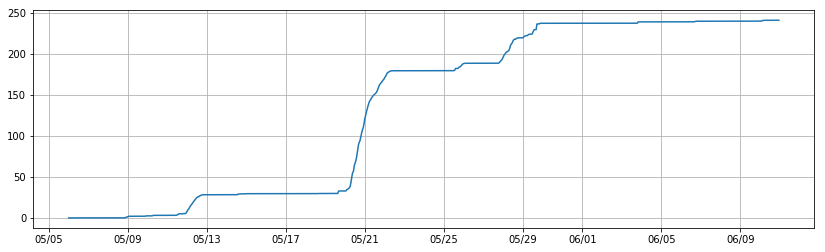

In [105]:
f_prec = "/media/x/cosmicsense/data/fendt/dwd/stundenwerte_RR_02290_akt/produkt_rr_stunde_20171208_20190610_02290.txt"
prec = pd.read_csv(f_prec, sep=";", na_values=-999)

prec.columns = ["station_id", "datetime", "quality", "depth", "ind", "wrtr", "eor"]
prec.datetime = pd.to_datetime(prec.datetime, format="%Y%m%d%H")
prec = prec.set_index("datetime")

fig = plt.figure(figsize=(14, 4))
ax = plt.subplot(111)
plt.plot(prec["2019-05-06":].index, prec["2019-05-06":].depth.cumsum())
#prec["2019-05-06":].depth.cumsum().plot()
plt.grid() 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

## Read raw data

#### CRNS records from three probes with different temporal coverage

In [106]:
ids = [1, 2, 3, 4, 5, 6, 7, 8, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25]

#fpath = "/home/maik/b2drop/cosmicsense/inbox/fendt/timeseries/crns/JFC-1/"
fpath = "/media/x/cosmicsense/data/fendt/crns/"

In [107]:
crns = {}
for id in ids:
    df = pd.read_csv(path.join(fpath, "%d/%d_CRNS_merge.txt" % (id, id)), sep="\t")
    df.datetime = pd.to_datetime(df.datetime)
    df = df.set_index("datetime")
    if id==4:
        df["cph1"] = (df.counts1 + df.counts2) / cs.conv.s_to_h(df.nsecs1)
    else:
        df["cph1"] = df.counts1 / cs.conv.s_to_h(df.nsecs1)
        try:
            df["cph2"] = df.counts2 / cs.conv.s_to_h(df.nsecs2)
        except AttributeError:
            pass
    print(id, end=": ")
    print("%s to %s" % (df.index[0], df.index[-1]) )
    crns[id] = df

1: 2019-05-09 09:59:00 to 2019-06-13 07:19:00
2: 2019-05-07 11:02:13 to 2019-06-13 05:40:00
3: 2019-05-07 08:37:25 to 2019-06-13 09:26:00
4: 2019-05-07 15:21:29 to 2019-06-13 05:39:00
5: 2019-05-03 08:53:04 to 2019-06-07 08:37:00
6: 2019-05-03 09:34:48 to 2019-06-07 08:41:00
7: 2019-05-13 14:54:00 to 2019-06-07 09:40:00
8: 2019-05-01 00:46:00 to 2019-06-07 08:46:00
14: 2019-05-08 06:45:44 to 2019-05-31 09:19:00
16: 2019-05-14 13:45:00 to 2019-06-12 16:31:00
17: 2019-05-15 14:14:46 to 2019-06-12 14:26:00
18: 2019-05-14 10:16:06 to 2019-06-06 14:35:00
19: 2019-05-14 12:45:49 to 2019-06-13 09:00:00
21: 2019-05-13 13:38:38 to 2019-06-10 20:56:00
22: 2019-05-13 15:24:44 to 2019-06-10 21:18:00
23: 2019-05-15 15:55:32 to 2019-06-13 10:19:00
24: 2019-05-15 15:09:58 to 2019-06-12 15:19:00
25: 2019-05-14 10:02:00 to 2019-06-07 08:41:00


In [108]:
min_dtime = np.min([crns[key].index[0] for key in crns.keys()])
max_dtime = np.max([crns[key].index[-1] for key in crns.keys()])

## Filter spurious signals

Some probes are affected by spurious count rates. In order to keep useful parts of the signal, a pragmatic/heuristic filtering approach is applied which could be refined later:

1. Remove entirely unrealisticly count rates for specific probes (`mincph`, `maxcph`)
2. Remove count rates from spuriously short count intervals (`mininterv`)
3. After that, there are still spurious count rates.In order to detect these, we compute the maximum count rates over periods of six hours, and then apply a 24-hour-median filter to these 6-hour-maxima. That way, we try to truncate spurios peaks. In order to prevent too aggressive filtering, we add a `buffer` of the median count rates over a period of 24 hours.
4. We then interpolate this upper limit filter to the original timestamp values and use it to remove high values.
5. We remove unrealisticly low count rates (`mincph`), and than apply the same approach (points 3-4) to eliminate spuriously small values.  

In [109]:
pars =  {
    1: {"mincph": 500, "maxcph": 1000, "mininterv": -9999, "type": "CRS 2000-B, Scn.", "lut": "forest/meadow"},
    2: {"mincph": 500, "maxcph": 1100, "mininterv": -9999, "type": "CRS 1000", "lut": "meadow"},
    3: {"mincph": 500, "maxcph": 1100, "mininterv": -9999, "type": "CRS 1000", "lut": "meadow"},
    4: {"mincph": 6000, "maxcph": 9500, "mininterv": -9999, "type": "Lab C", "lut": "meadow"},
    5: {"mincph": 800, "maxcph": 1500, "mininterv": -9999, "type": "CRS 1000-B", "lut": "meadow"},
    6: {"mincph": 800, "maxcph": 1500, "mininterv": -9999, "type": "CRS 1000-B", "lut": "meadow, forest close"},
    7: {"mincph": 1000, "maxcph": 1700, "mininterv": -9999, "type": "CRS 1000-B", "lut": "meadow"},
    8: {"mincph": 1300, "maxcph": 2500, "mininterv": -9999, "type": "CRS 2000-B", "lut": "meadow"},
    14: {"mincph": 800, "maxcph": 1500, "mininterv": -9999, "type": "CRS 2000", "lut": "forest"},
    16: {"mincph": 1500, "maxcph": 2500, "mininterv": -9999, "type": "CRS 2000-B", "lut": "meadow"},
    17: {"mincph": 1400, "maxcph": 2400, "mininterv": -9999, "type": "CRS 2000-B", "lut": "meadow"},
    18: {"mincph": 500, "maxcph": 1000, "mininterv": -9999, "type": "CRS 1000", "lut": "meadow"},
    19: {"mincph": 1300, "maxcph": 2300, "mininterv": -9999, "type": "CRS 2000-B", "lut": "forest"},
    21: {"mincph": 1400, "maxcph": 2300, "mininterv": -9999, "type": "CRS 2000-B", "lut": "meadow, forest close"},
    22: {"mincph": 1100, "maxcph": 2100, "mininterv": -9999, "type": "CRS 2000-B", "lut": "forest"},
    23: {"mincph": 1200, "maxcph": 2200, "mininterv": -9999, "type": "CRS 2000-B", "lut": "meadow, peat"},
    24: {"mincph": 1600, "maxcph": 2600, "mininterv": -9999, "type": "CRS 2000-B", "lut": "meadow"},
    25: {"mincph": 900, "maxcph": 1500, "mininterv": -9999, "type": "CRS 1000-B", "lut": "meadow"},
    
}

buffer = 0.075

for i, key in enumerate(crns.keys()):
    x = crns[key].cph1.copy()
    if not key==1:
        x[x > pars[key]["maxcph"]] = np.nan
    x[x < pars[key]["mincph"]] = np.nan
    x[crns[key].nsecs1 < pars[key]["mininterv"]] = np.nan
    median24 = x.resample("24H").median()
    # Maxfilter
    max6 = x.resample("6H").max()
    median24max6 = max6.resample("24H").median()
    maxfilter = np.array(median24max6 + buffer * median24)
    # Minfilter
    min6 = x.resample("6H").min()
    median24min6 = min6.resample("24H").median()
    minfilter = np.array(median24min6 - buffer * median24)    
    # Resample filter to original time stamps
    crns[key]["cph1_maxfilter"] = np.interp(x.index, median24.index, maxfilter)
    crns[key]["cph1_minfilter"] = np.interp(x.index, median24.index, minfilter)
    # Fill gaps
    crns[key]["cph1_maxfilter"] = crns[key].cph1_maxfilter.interpolate()
    crns[key]["cph1_minfilter"] = crns[key].cph1_minfilter.interpolate()
    # Apply filter
    crns[key]["cph1_filtered"] = x
    if not key==1:
        crns[key].loc[crns[key].cph1 > crns[key].cph1_maxfilter, "cph1_filtered"] = np.nan
        crns[key].loc[crns[key].cph1 < crns[key].cph1_minfilter, "cph1_filtered"] = np.nan

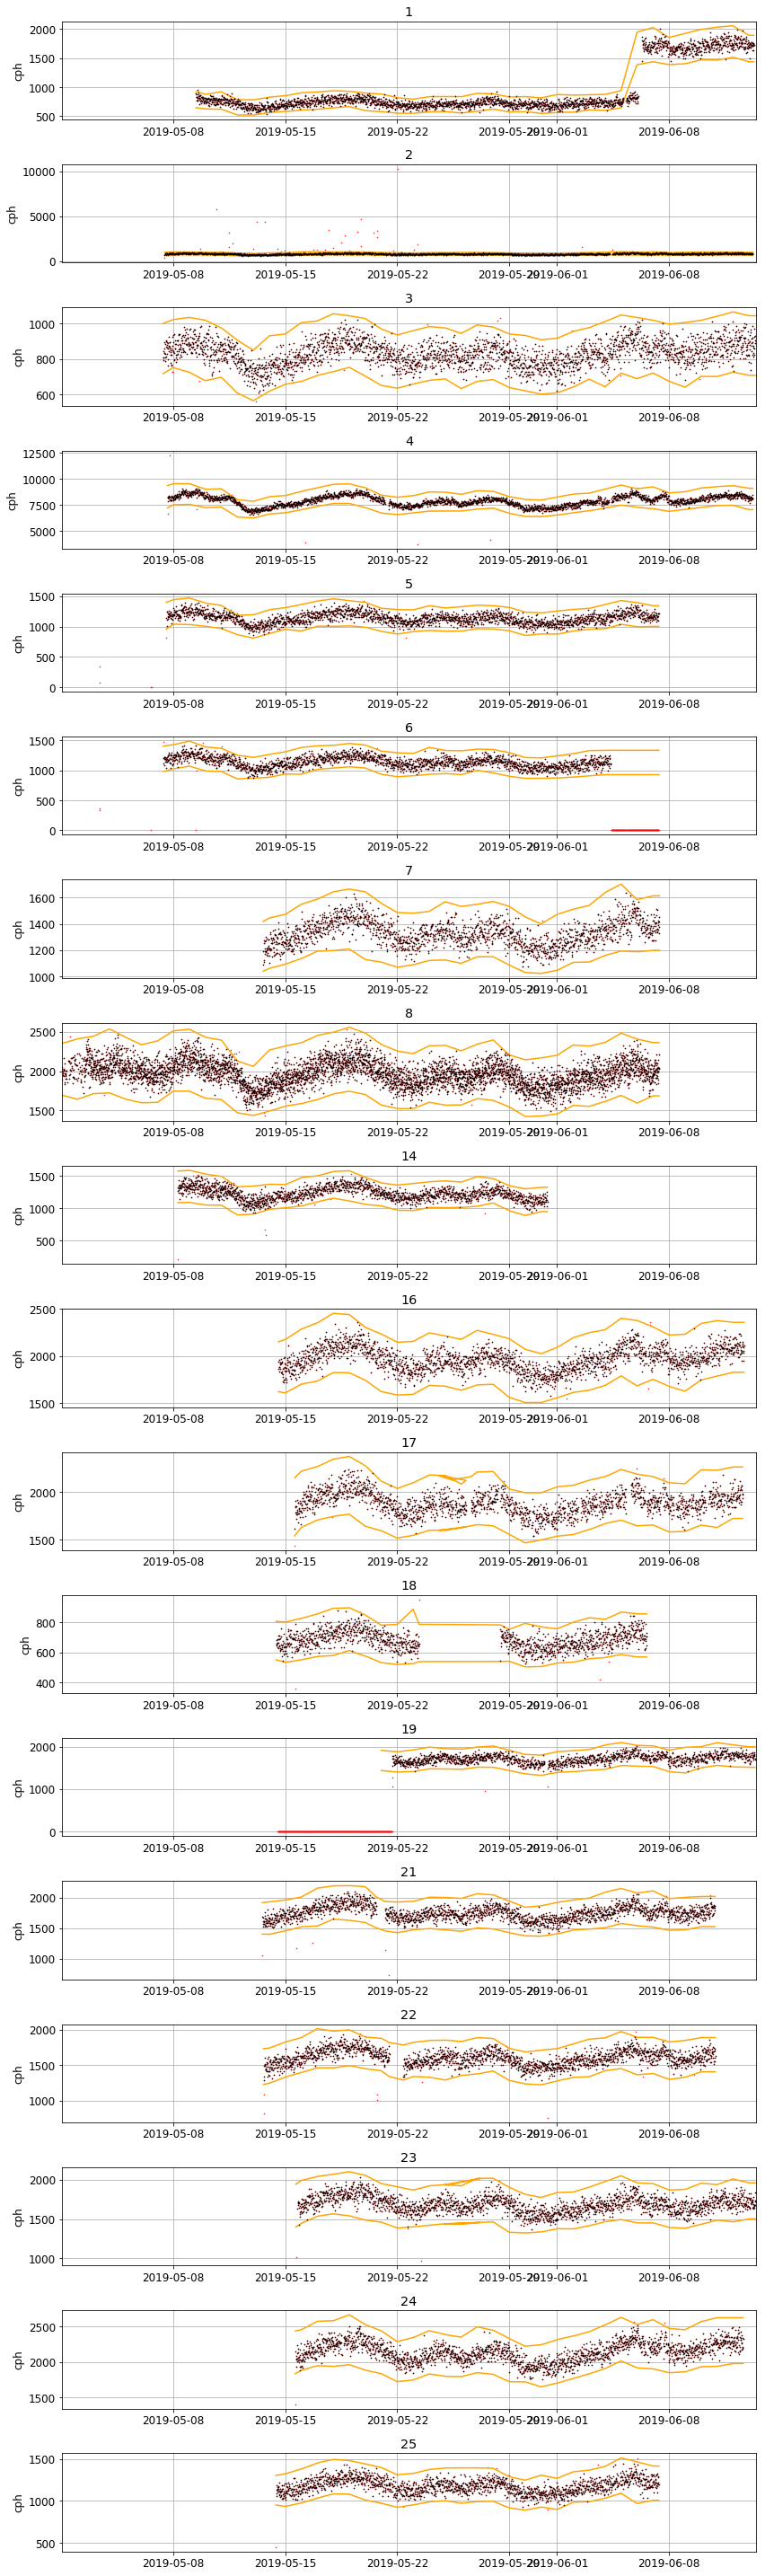

In [110]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=len(crns), figsize=(12,40))

xlim = min_dtime, max_dtime

for i, key in enumerate(crns.keys()):
    ax[i].plot(crns[key].index, crns[key].cph1, linestyle="None", marker=".", ms=1, color="red")
    ax[i].plot(crns[key].index, crns[key].cph1_maxfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_minfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_filtered, linestyle="None", marker=".", ms=1, color="black")
    ax[i].set_title(key)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("cph")
    ax[i].set_xlim(xlim)
    #ax[i].set_ylim(pars[key]["mincph"], pars[key]["maxcph"]+200)
    ax[i].grid()
    #ax[i].legend()    
    
plt.tight_layout()

## Resample to a common time interval

In [111]:
min_dtime, max_dtime

(Timestamp('2019-05-01 00:46:00'), Timestamp('2019-06-13 10:19:00'))

In [112]:
dtrange6 = pd.date_range('2019-05-01 00:00:00', max_dtime, freq="6H")
dtrange24 = pd.date_range('2019-05-01 00:00:00', max_dtime, freq="24H")
crns6h = pd.DataFrame({}, index=dtrange6)
crns24h = pd.DataFrame({}, index=dtrange24)

for i, key in enumerate(crns.keys()):
    crns6h = pd.merge(crns6h, crns[key].cph1_filtered.resample("6H").mean(), 
                      how="left", left_index=True, right_index=True)
    crns6h[key] = crns6h.cph1_filtered
    crns6h = crns6h.drop("cph1_filtered", axis=1)
    # 24 h
    crns24h = pd.merge(crns24h, crns[key].cph1_filtered.resample("24H").mean(), 
                      how="left", left_index=True, right_index=True)
    crns24h[key] = crns24h.cph1_filtered
    crns24h = crns24h.drop("cph1_filtered", axis=1)

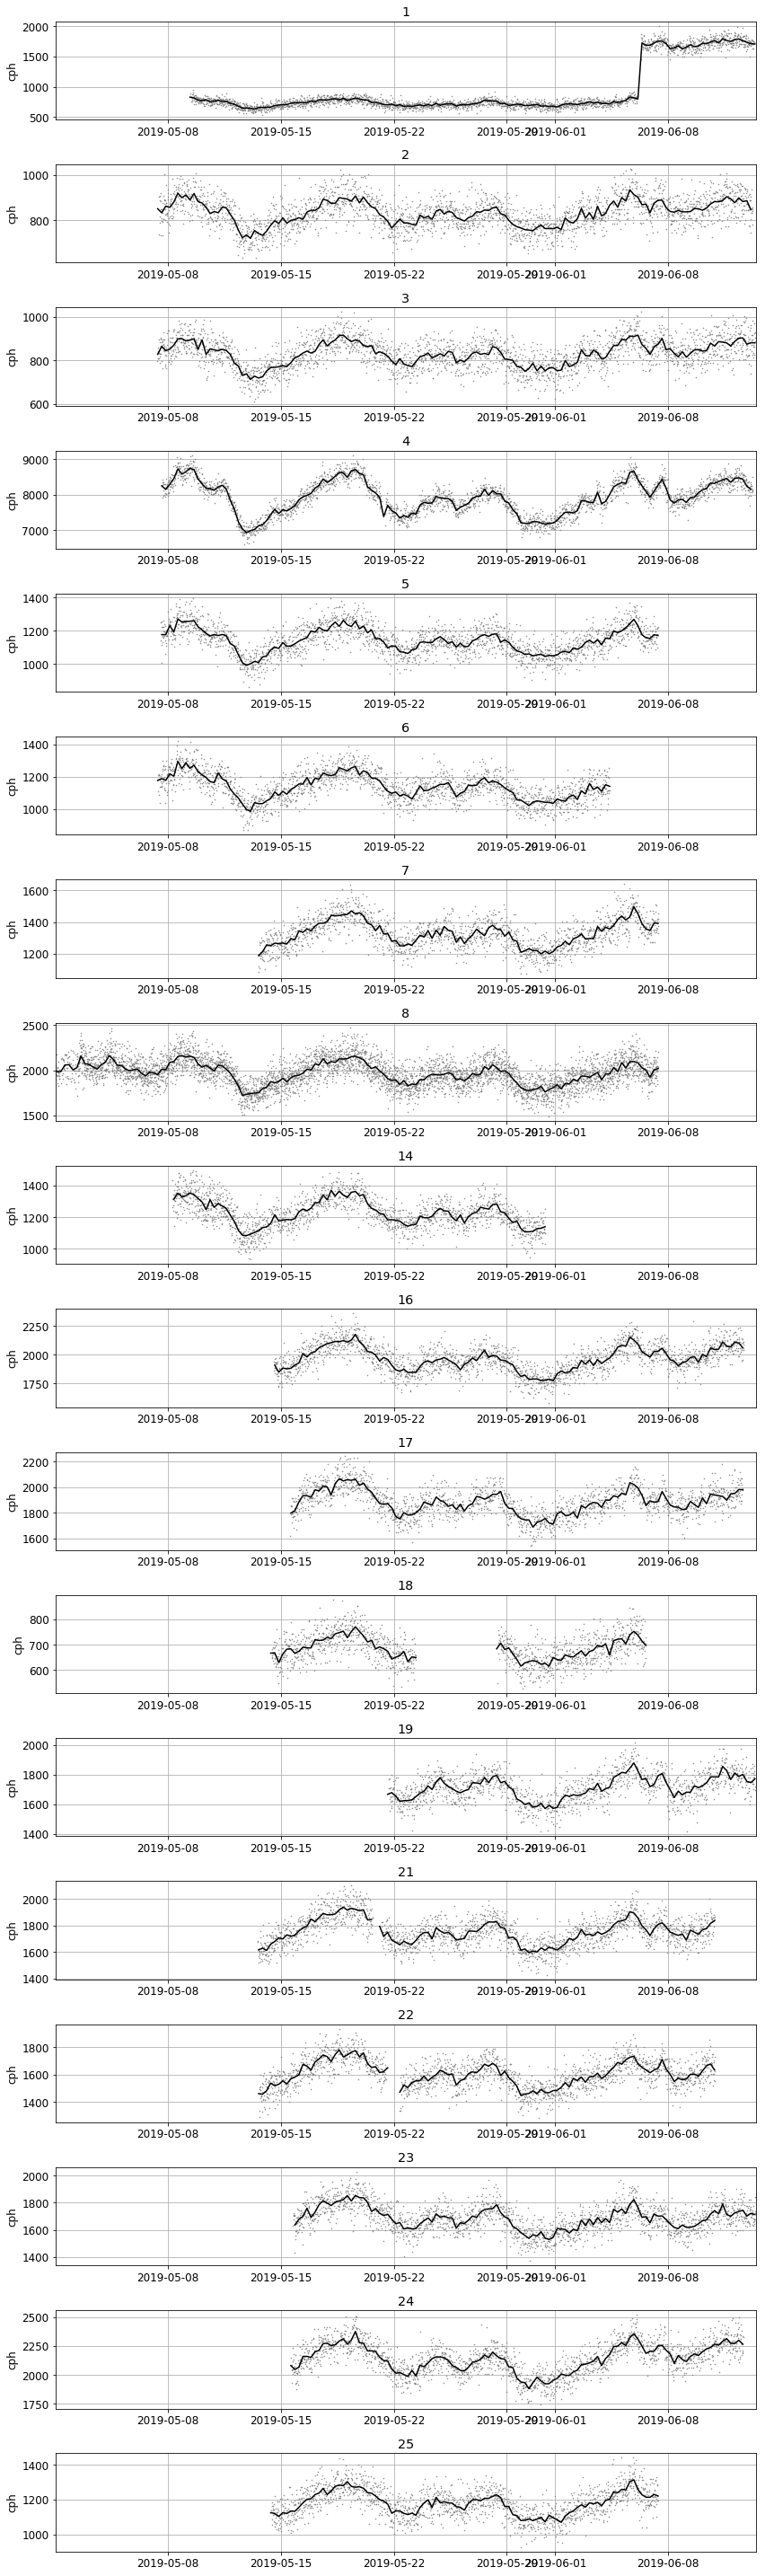

In [113]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=len(crns), figsize=(12,40))

xlim = min_dtime, max_dtime

for i, key in enumerate(crns.keys()):
    ax[i].plot(crns[key].index, crns[key].cph1_filtered, linestyle="None", marker=".", ms=1, color="grey")
    ax[i].plot(crns6h.index + dt.timedelta(hours=3), crns6h[key], "k-")#linestyle="None", marker="None", ms=1, color="black")
    ax[i].set_title(key)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("cph")
    ax[i].set_xlim(xlim)
    ax[i].grid()
    
plt.tight_layout()

/home/maik/miniconda3/envs/cosmic-sense/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/maik/miniconda3/envs/cosmic-sense/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


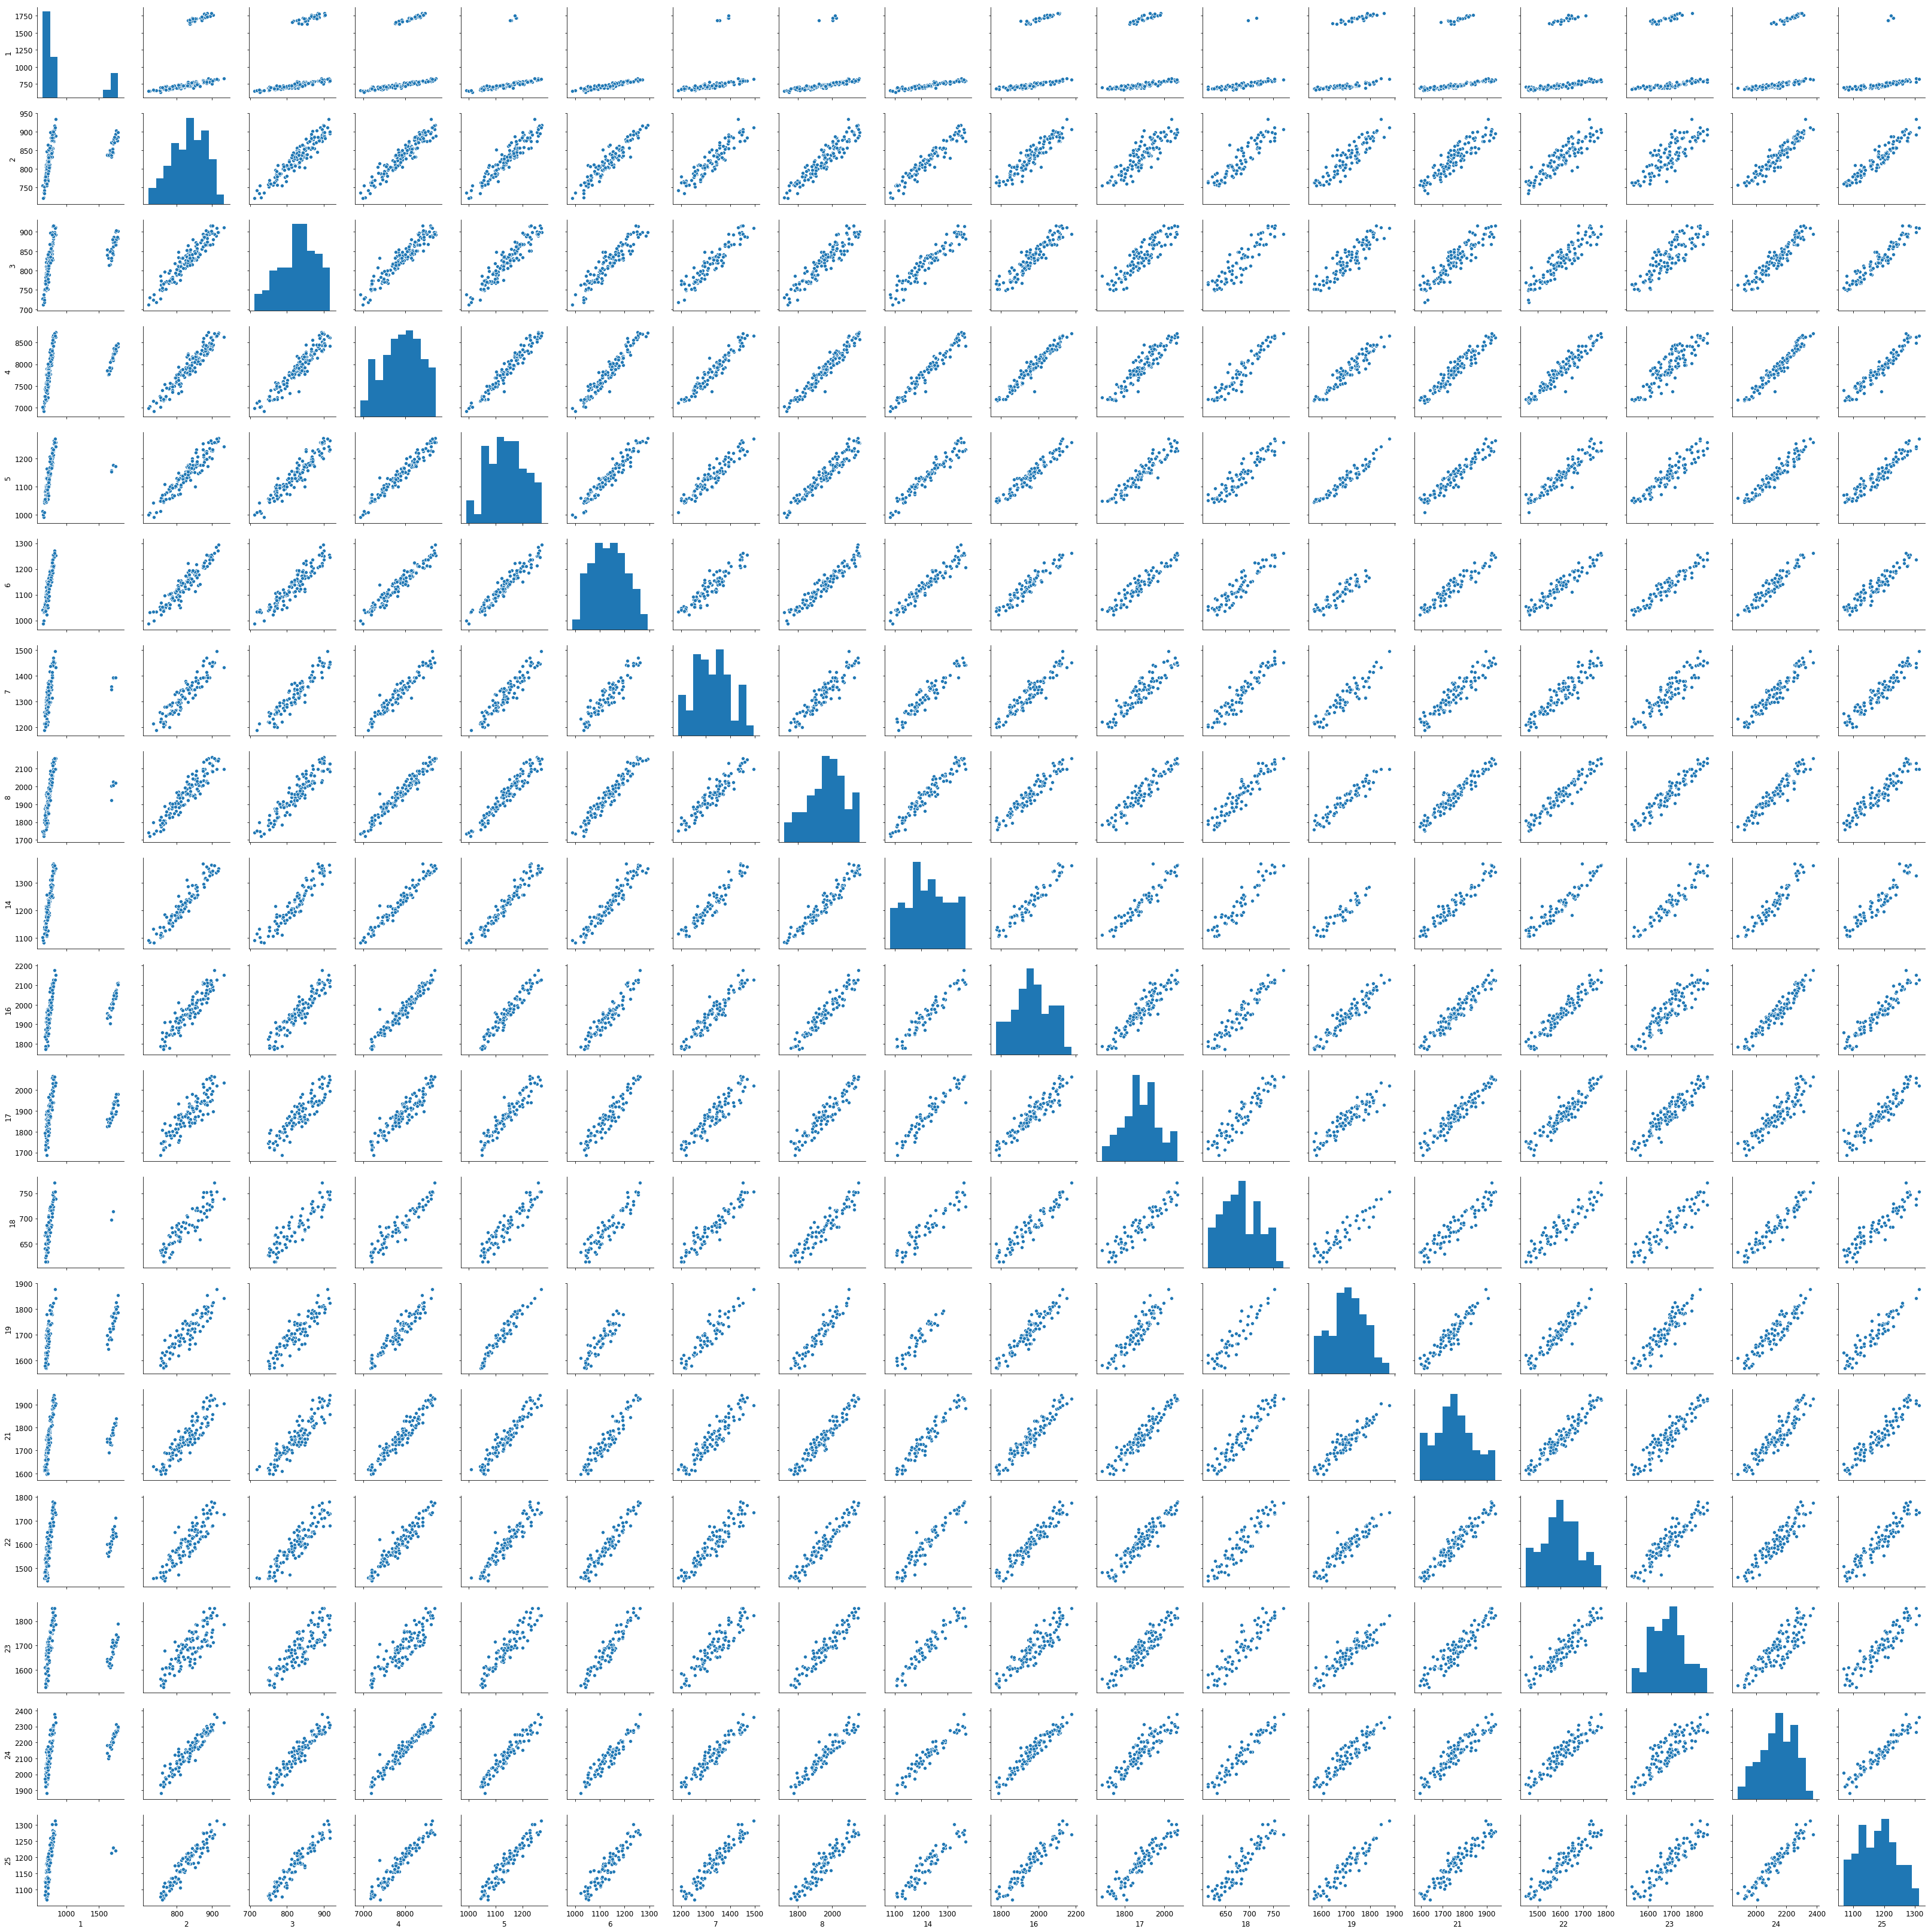

In [114]:
pp = sb.pairplot(crns6h)#, plot_kws=dict(edgecolor="None", s=6))

## Correcting for variations in incoming neutron flux

#### NMBD station data

`nmdb.txt` contains reference (background) neutron count rates from [NMDB](http://www.nmdb.eu/nest/), for stations `KIEL2`, `JUNG`, `JUNG1`, and `DRBS` (Dourbes, Belgium). 

In [115]:
# NMDB data
nmdb = pd.read_csv("/media/x/cosmicsense/data/fendt/nmdb/nmdb.txt", sep=";", 
                   comment="#", na_values="   null")
nmdb.datetime = pd.to_datetime(nmdb.datetime)
nmdb = nmdb.set_index("datetime")

Text(0.5, 1.0, 'Incoming neutron flux at Jungfraujoch')

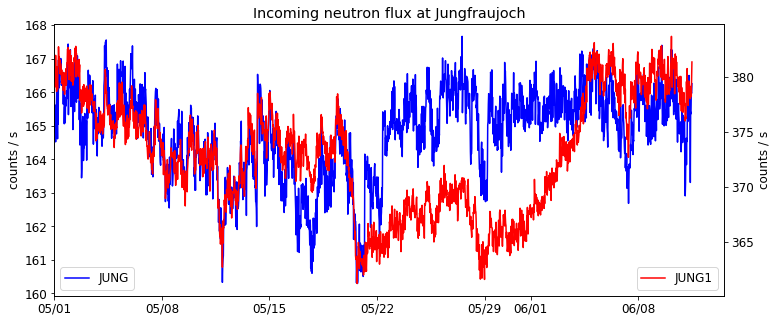

In [116]:
fig, ax1 = plt.subplots(figsize=(12, 5))
plt.plot(nmdb.index, nmdb.JUNG, "b-", label="JUNG")
plt.ylabel("counts / s")
plt.legend()

ax2 = ax1.twinx()
plt.plot(nmdb.index, nmdb.JUNG1, "r-", label="JUNG1")
plt.ylabel("counts / s")
leg = plt.legend(loc="lower right")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.title("Incoming neutron flux at Jungfraujoch")

Several literature references (e.g. Zreda et al. 2012, Schroen et al. 2015, Andreasen et al. 2017) suggest to correct for variations in incoming neutron fluxes based on cosmic-ray neutron monitors available through http://www.nmdb.eu/nest. The idea is to compute a simple scaling factor $f_i$ based on measure neutron intensity $f_m$ and an arbitrary reference intensity $f_{ref}$ that depends on the actual neutron monitor.

\begin{equation*}
f_i = \frac{I_m}{I_{ref}}
\end{equation*}

In the dissertation thesis of Schroen (2016), a reference value $f_{ref}$ of 150 cps is suggested for the monitor on Jungfraujoch (JUNG).

(737179.9902777778, 737223.575)

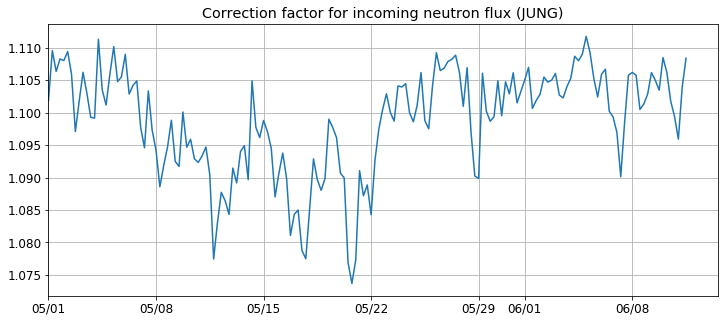

In [117]:
fi = (nmdb.JUNG / 150.).resample("6H").mean()
fi.name="fi"

fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(fi.index, fi)
plt.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.title("Correction factor for incoming neutron flux (JUNG)")
plt.xlim(min_dtime-dt.timedelta(hours=1), None)

## Correcting for variations in barometric pressure

Again based on Zreda et al. (2012), Andreasen et al. (2017) and many others, a correction factor $f_p$ is suggested in order to account for variations in barometric pressure.

\begin{equation*}
f_p = exp\Bigl(\frac{p_0 - p}{L}\Bigl)
\end{equation*}

Quoting from [Andreasen et al. (2017)](https://dl.sciencesocieties.org/publications/vzj/pdfs/16/8/vzj2017.04.0086):

> [...] $L$  is  the  mass  attenuation  length  for  high-energy  neutrons and is a function of cutoff rigidity
> (Desilets et al., 2006), $p$ is the barometric pressure at the time of measurement, and $P_0$ is an arbitrary
> reference pressure. Note that the units of $L$, $p$, and $p_0$ can be shielding depth (g/cm2) or pressure (Pa), 
> where $1 g/cm2 = 98.0665 Pa$. If shielding depth is used, $L$ ranges from 130 g/cm2 at high latitudes to 
> 144 g/cm2 at the equator (see Fig. 1).

[Zreda et al. (2012)](https://www.hydrol-earth-syst-sci.net/16/4079/2012/hess-16-4079-2012.pdf) complement that

> [... $p_0$] can be selected to be the long-term average pressure at the specific site, sea-level pressure, 
> or long-term averagepressure at a different reference site.

How do we quantify $p_0$? Based on site average, or just based on standard sea level pressure (1013 mbar)?**

For now, we use $p_0 = 1013.25 mbar = 101325 Pa = 1033.23 g/cm²$ or site average, and $L=131.6$ for Germany (Fig. 1 in Andreasen et al. (2017).

In [118]:
f_press = "/media/x/cosmicsense/data/fendt/dwd/stundenwerte_P0_02290_akt/produkt_p0_stunde_20171208_20190610_02290.txt"
press = pd.read_csv(f_press, sep=";", na_values=-999)
press.columns = ["station_id", "datetime", "quality", "p", "p0", "eor"]
press.datetime = pd.to_datetime(press.datetime, format="%Y%m%d%H")
press = press.set_index("datetime")

In [119]:
p_0 = press.p0.mean()
L = 131.6 # g/cm2
fp = cs.core.corrfact_baro(press.p0, p_0, L)

fp = fp.resample("6H").mean()
fp.name="fp"

Text(0.5, 1.0, 'Correction factor for barometric pressure')

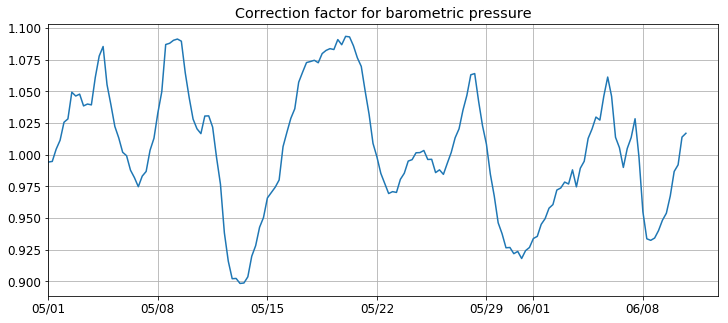

In [120]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(fp["2019-05-01":].index, fp["2019-05-01":])
plt.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.title("Correction factor for barometric pressure")

## Correcting for variations in atmospheric water vapor

In their overview, Andreasen et al. (2017) refer to Rosolem et al. (2013) when accounting for the effects of atmospheric water vapor:

\begin{equation*}
f_{wv} = 1 + 0.0054 * (h - h_{ref})
\end{equation*}

where $h$ is the absolute humidity of the air (in g/m3), and $h_{ref}$ is the absolute humidity at an arbitrary reference time.

The references do not elaborate on how to obtain the absolute humidity, but given the relative humidity and air temperature, we typically obtain $h$ by combining 

1. Relationship between vapor pressure $e$, saturated vapor pressure $e_s$ and relative humidity $rh$ (in %)

\begin{equation*}
e = e_s * rh / 100.
\end{equation*}

2. August-Roche-Magnus approximation of relation betweeen $e_s$ (mbar) and air temperature $T$ (in deg C) 

\begin{equation*}
e_s(T) = 6.1094 * exp\Bigl(\frac{17.625*T}{T + 243.04}\Bigl)
\end{equation*}

3. Universal law of perfect gases (with volume $V$, mass $m$, specific gas constant $R_S=461.4 J/kg/K$ for water vapor)

\begin{equation*}
e * V = m * R_s * T
\end{equation*}

In [121]:
# dummy correction factor for humidity
fwv = pd.Series(data=np.ones(len(crns6h.index)), index=crns6h.index)
fwv.name = "fwv"

## Combining the correction factors

We can now inspect the different correction factor, and use them to correct our neutron counts. According to Andreasen, this is done via

\begin{equation*}
N_{cor} = \frac{N*f_{wv}}{f_p*f_i}
\end{equation*}

In [122]:
crns6hc = crns6h.copy()
crns6hc = pd.merge(crns6hc, fi, how='left', left_index=True, right_index=True)
crns6hc = pd.merge(crns6hc, fp, how='left', left_index=True, right_index=True)
crns6hc = pd.merge(crns6hc, fwv, how='left', left_index=True, right_index=True)
for id in ids:
    crns6hc[id] = crns6hc[id] * crns6hc["fwv"] / (crns6hc["fi"] * crns6hc["fp"])

### Standardize all probes to one level (adjust to probe #4 - Lab C)

In [123]:
crns6hcst = crns6hc.copy()
#crns6hcst = crns6hcst.drop(columns=["fi", "fp", "fwv"])
for i, id in enumerate(ids):
    if id==19:
        fact = np.nanmean(crns6hc["2019-05-22":"2019-05-29"][4]) / np.nanmean(crns6hc["2019-05-22":"2019-05-29"][id])
        crns6hcst[id] = crns6hc[id] * fact
    elif id==1:
        #continue
        fact2 = np.nanmean(crns6hc["2019-06-06 12:00:00":"2019-06-12 00:00:00"][1]) / np.nanmean(crns6hc["2019-05-22":"2019-05-29"][1])
        crns1 = crns6hc[1].copy()
        crns1[:"2019-06-06 03:00:00"] *= fact2
        fact = np.nanmean(crns6hc["2019-05-22":"2019-05-29"][4]) / np.nanmean(crns1["2019-05-22":"2019-05-29"])
        crns1 *= fact
        crns6hcst[id] = crns1
    else:
        fact = np.nanmean(crns6hc["2019-05-15":"2019-05-22"][4]) / np.nanmean(crns6hc["2019-05-15":"2019-05-22"][id])
        crns6hcst[id] = crns6hc[id] * fact

In [124]:
crns24chst = crns6hcst.resample("24H").mean()

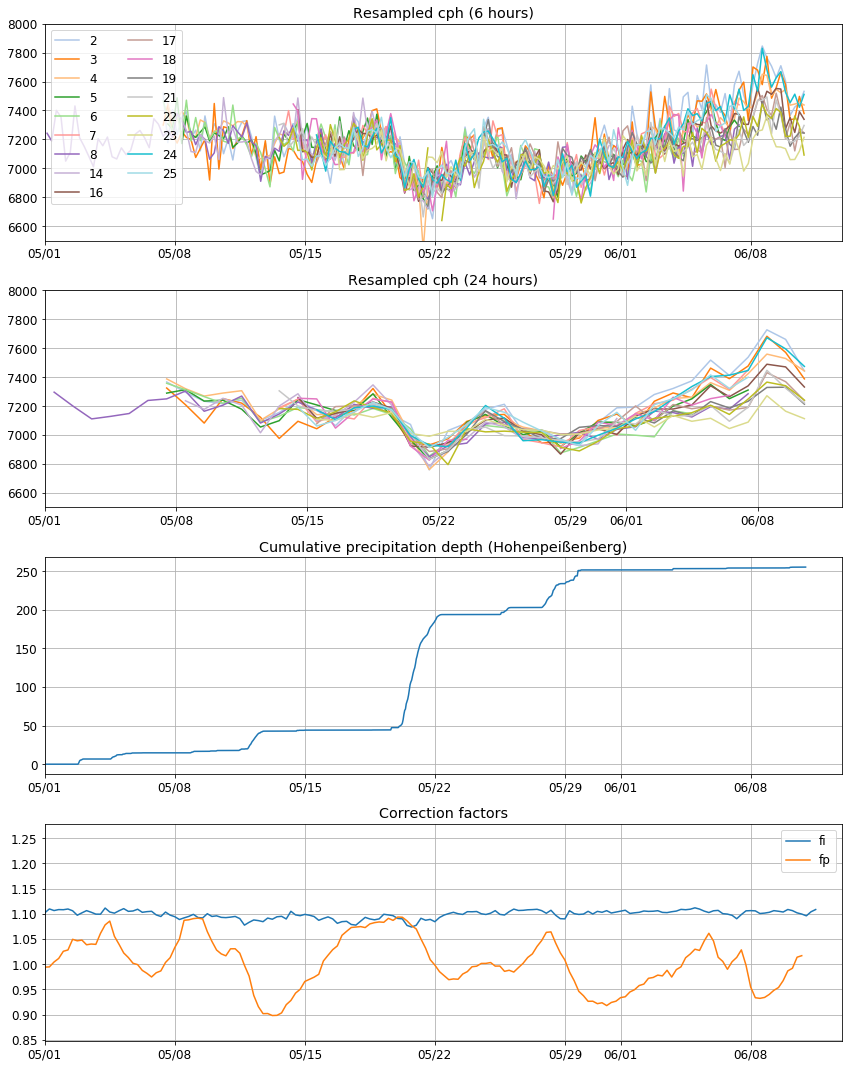

In [125]:
plt.rc('font', **{'size'   : 12})
colors = plt.cm.tab20(np.linspace(0,1,len(ids)))
fig = plt.figure(figsize=(12,15))
ax1 = fig.add_subplot(411)

#pl = crns6hcst.resample("24H").mean().plot(y=ids, ax=ax1, color=colors)
#crns6hcst.plot(ax=ax1, color=colors)
for i, id in enumerate(ids):
    if id==1:
        continue
        #pass
    ax1.plot(crns6hcst.index+dt.timedelta(hours=3), crns6hcst[id], color=colors[i])
    #ax1.plot(crns24chst.index+dt.timedelta(hours=12), crns24chst[id], color=colors[i])
ax1.legend(ncol=2)
plt.ylim(6500, 8000)
plt.grid()
plt.title("Resampled cph (6 hours)")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)

ax = fig.add_subplot(412)
crns24chst = crns6hcst.resample("24H").mean()
#pl = crns6hcst.resample("24H").mean().plot(y=ids, ax=ax1, color=colors)
#crns6hcst.plot(ax=ax1, color=colors)
for i, id in enumerate(ids):
    if id==1:
        continue
        #pass
    #ax1.plot(crns6hcst.index+dt.timedelta(hours=3), crns6hcst[id], color=colors[i])
    ax.plot(crns24chst.index+dt.timedelta(hours=12), crns24chst[id], color=colors[i])
#ax.legend(ncol=2)
plt.ylim(6500, 8000)
plt.grid()
plt.title("Resampled cph (24 hours)")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)

ax2 = fig.add_subplot(413)
ax2.plot(prec["2019-05-01":].index, prec["2019-05-01":].depth.cumsum())
#prec[crns6hcst.index[0]:crns6hcst.index[-1]].depth.cumsum().plot()
ax2.set_xlim(ax1.get_xlim())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.grid()
plt.title("Cumulative precipitation depth (Hohenpeißenberg)")

ax3 = fig.add_subplot(414)
ax3.plot(fi.index, fi, label="fi")
ax3.plot(fp.index, fp, label="fp")
ax3.set_xlim(ax1.get_xlim())
ax3.legend()
plt.grid()
plt.title("Correction factors")
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)

plt.tight_layout()


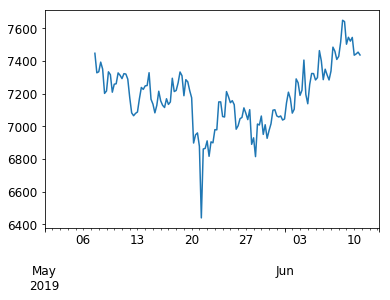

In [126]:
crns6hcst[4].plot()

(6000, 9000)

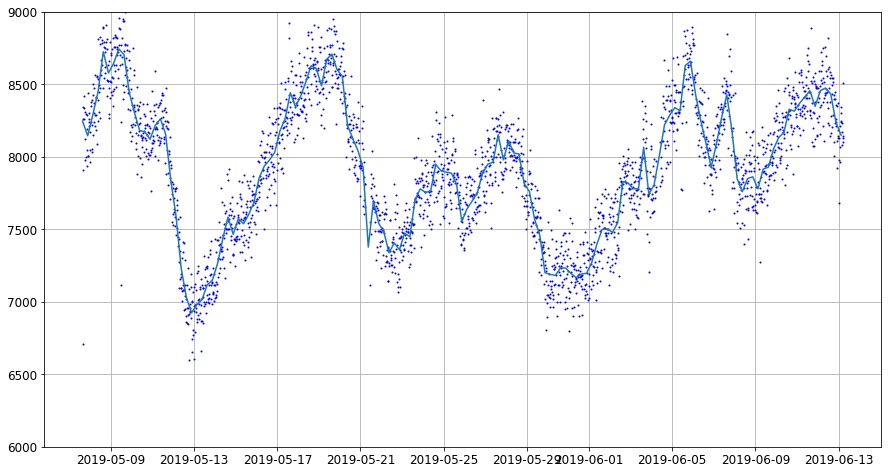

In [127]:
plt.figure(figsize=(15,8))
plt.plot(crns[4].cph1.index, crns[4].cph1, "bo", ms=1)
plt.plot(crns6h.index + dt.timedelta(hours=3), crns6h[4])
plt.grid()
plt.ylim(6000, 9000)